In [4]:
# magic command to display matplotlib plots inline within the ipython notebook
%matplotlib inline

# import necessary modules
import pandas as pd, numpy as np, matplotlib.pyplot as plt, time
from sklearn.cluster import DBSCAN
from sklearn import metrics
from geopy.distance import great_circle
from shapely.geometry import MultiPoint

In [36]:
# define the number of kilometers in one radian
kms_per_radian = 6371.0088

In [37]:
# load the data set
df = pd.read_csv('dm_clean_final.csv')
df.head()

,photoID,latitude,longitude,userID,photoLink,photoTags,DateTaken
0,1151334893,45.33,5.95,75174621@N00,http://farm2.staticflickr.com/1070/1151334893_...,france infrared provence rhnealpes aplusphot...,1185114234
1,1151332465,45.33,5.96,75174621@N00,http://farm2.staticflickr.com/1216/1151332465_...,france provence rhnealpes tencin kmtotencini...,1185113754
2,1438670393,40.75,14.49,13897419@N02,http://farm2.staticflickr.com/1100/1438670393_...,italy volcano ruins campania kodak scanned po...,589039200
3,1438658045,40.75,14.49,13897419@N02,http://farm2.staticflickr.com/1040/1438658045_...,italy ruins campania kodak scanned pompeii ko...,589032000
4,1439150203,42.64,18.12,13897419@N02,http://farm2.staticflickr.com/1106/1439150203_...,boats fishing kodak croatia scanned kodachrom...,606758400


In [38]:
# how many rows are in this data set?
len(df)

2812678

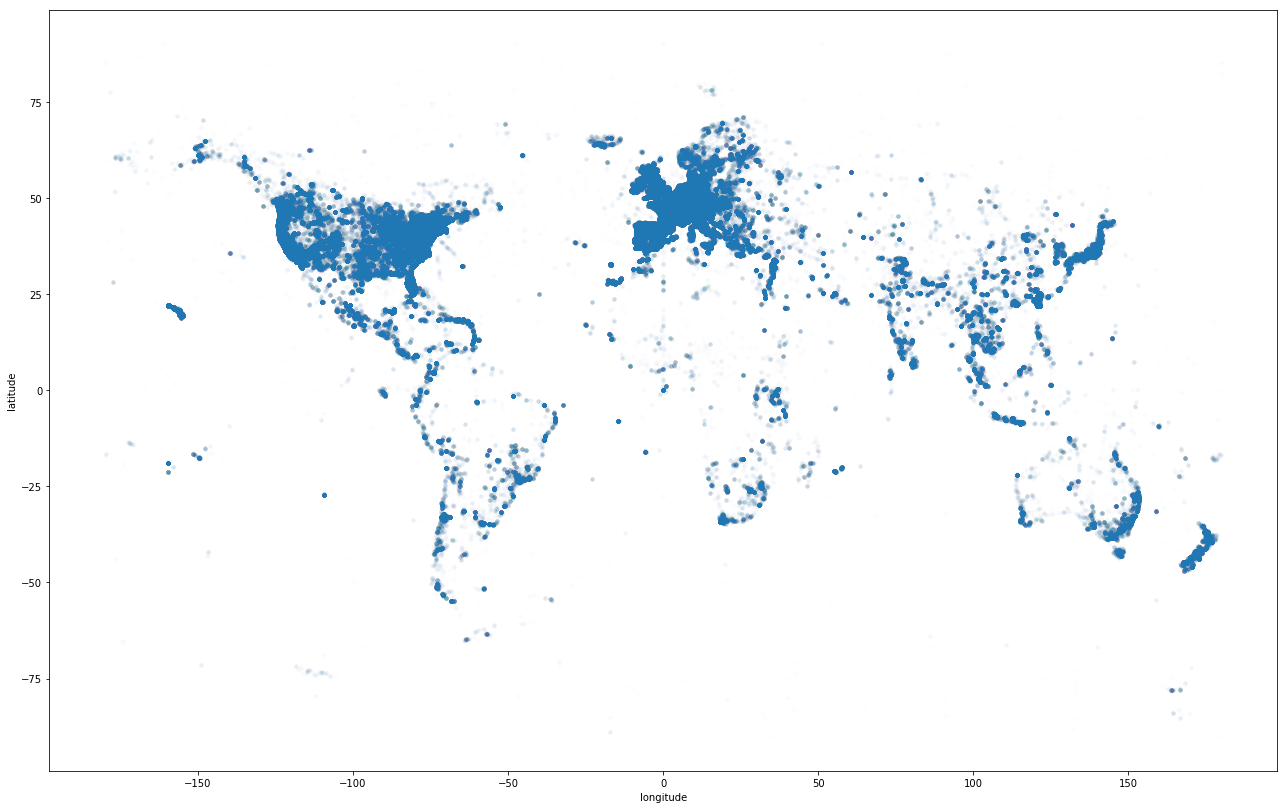

In [26]:
This map is for 3.6 million point before rounding*****************************************************************************
# scatterplot it to get a sense of what it looks like
df = df.sort_values(by=['latitude', 'longitude'])
ax = df.plot(kind='scatter', x='longitude', y='latitude', alpha=0.01, linewidth=0, figsize=(22,14))

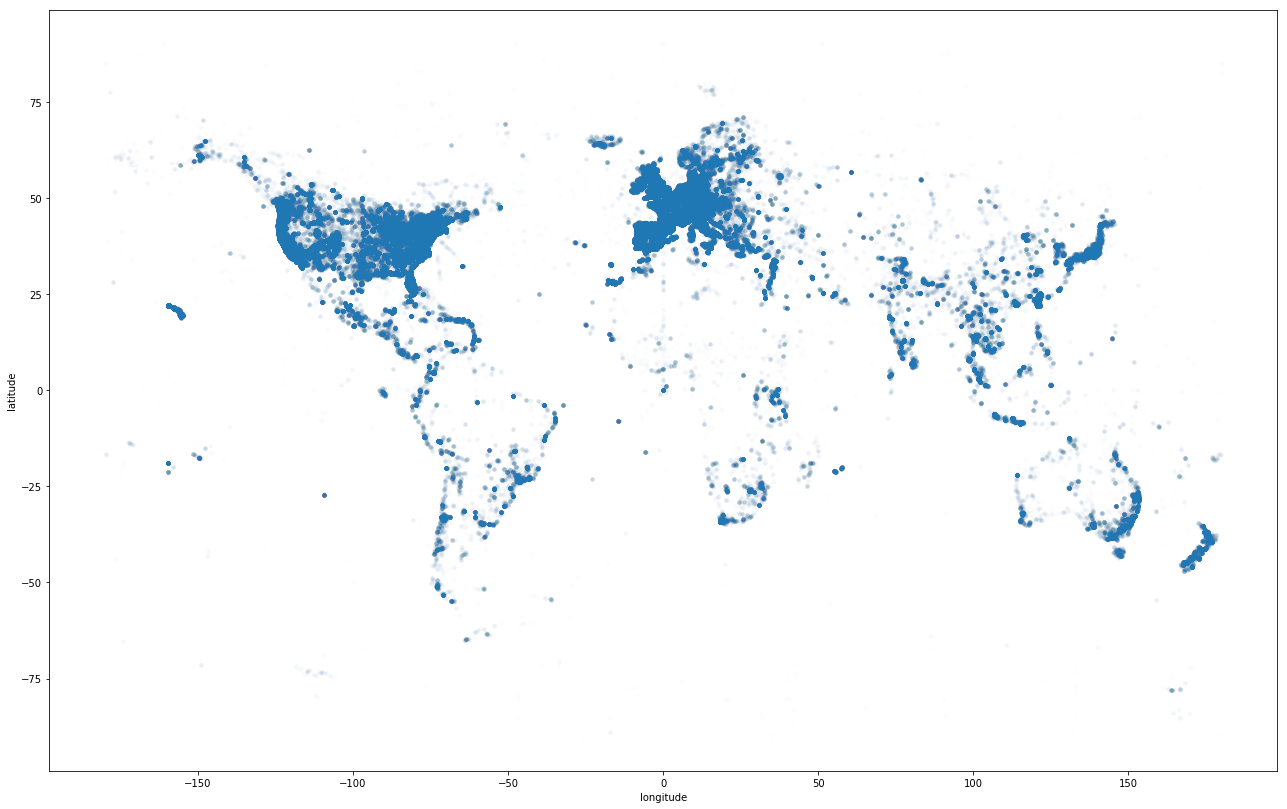

In [39]:
# scatterplot it to get a sense of what it looks like
df = df.sort_values(by=['latitude', 'longitude'])
ax = df.plot(kind='scatter', x='longitude', y='latitude', alpha=0.01, linewidth=0, figsize=(22,14))

In [40]:
# represent points consistently as (lat, lon)
coords = df.as_matrix(columns=['latitude', 'longitude'])

# define epsilon as 10 kilometers, converted to radians for use by haversine

# set eps low (1.5km) so clusters are only formed by very close points
epsilon = 1.5 / kms_per_radian

# set min_samples to 1 so we get no noise - every point will be in a cluster even if it's a cluster of 1
start_time = time.time()
db = DBSCAN(eps=epsilon, min_samples=1, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
cluster_labels = db.labels_
unique_labels = set(cluster_labels)

# get the number of clusters
num_clusters = len(set(cluster_labels))

# all done, print the outcome
message = 'Clustered {:,} points down to {:,} clusters, for {:.1f}% compression in {:,.2f} seconds'
print(message.format(len(df), num_clusters, 100*(1 - float(num_clusters) / len(df)), time.time()-start_time))

Clustered 2,812,678 points down to 139,691 clusters, for 95.0% compression in 990.98 seconds


In [42]:
# number of clusters, ignoring noise if present
num_clusters = len(set(cluster_labels)) #- (1 if -1 in labels else 0)
print('Number of clusters: {}'.format(num_clusters))

Number of clusters: 139691


In [43]:
# create a series to contain the clusters - each element in the series is the points that compose each cluster
clusters = pd.Series([coords[cluster_labels == n] for n in range(num_clusters)])
clusters.tail()

139686                                    [[86.08, -38.85]]
139687                                   [[86.98, -168.55]]
139688                                     [[87.48, 90.34]]
139689                                     [[87.48, 92.01]]
139690    [[89.99, 51.32], [89.99, 51.33], [90.0, -161.0...
dtype: object

In [44]:
# given a cluster of points, return the point nearest to the cluster's centroid
def get_centermost_point(cluster):
    centroid = (MultiPoint(cluster).centroid.x, MultiPoint(cluster).centroid.y)
    centermost_point = min(cluster, key=lambda point: great_circle(point, centroid).m)
    return tuple(centermost_point)

In [45]:
# find the point in each cluster that is closest to its centroid
centermost_points = clusters.map(get_centermost_point)

# unzip the list of centermost points (lat, lon) tuples into separate lat and lon lists
lats, lons = zip(*centermost_points)

# from these lats/lons create a new df of one representative point for each cluster
representative_points = pd.DataFrame({'lon':lons, 'lat':lats})
representative_points.tail()
representative_points.tail()

,lat,lon
139686,86.08,-38.85
139687,86.98,-168.55
139688,87.48,90.34
139689,87.48,92.01
139690,90.00,0.00


In [49]:
# pull row from full data set (df) where lat/lon match the lat/lon of each row of representative points
# use iloc[0] to pull just the first row if there are multiple matches
rs = representative_points.apply(lambda row: df[(df['latitude']==row['lat']) & (df['longitude']==row['lon'])].iloc[0], axis=1)
rs.to_csv('reduced-set.csv', index=False)
rs.tail()

,photoID,latitude,longitude,userID,photoLink,photoTags,DateTaken
139686,2778566720,86.08,-38.85,12963132@N07,http://farm4.staticflickr.com/3173/2778566720_...,mariposa,1041651130
139687,61763848,86.98,-168.55,64749615@N00,http://farm1.staticflickr.com/29/61763848_81d6...,,1123329940
139688,7491249140,87.48,90.34,11402767@N00,http://farm9.staticflickr.com/8294/7491249140_...,flickrandroidappfilternone,1341286061
139689,7888941828,87.48,92.01,11402767@N00,http://farm9.staticflickr.com/8319/7888941828_...,klout flickrandroidappfilternone,1346271835
139690,2999954441,90.00,0.00,84392129@N00,http://farm4.staticflickr.com/3240/2999954441_...,portrait woman cinema window movie notmine sar...,1225296044


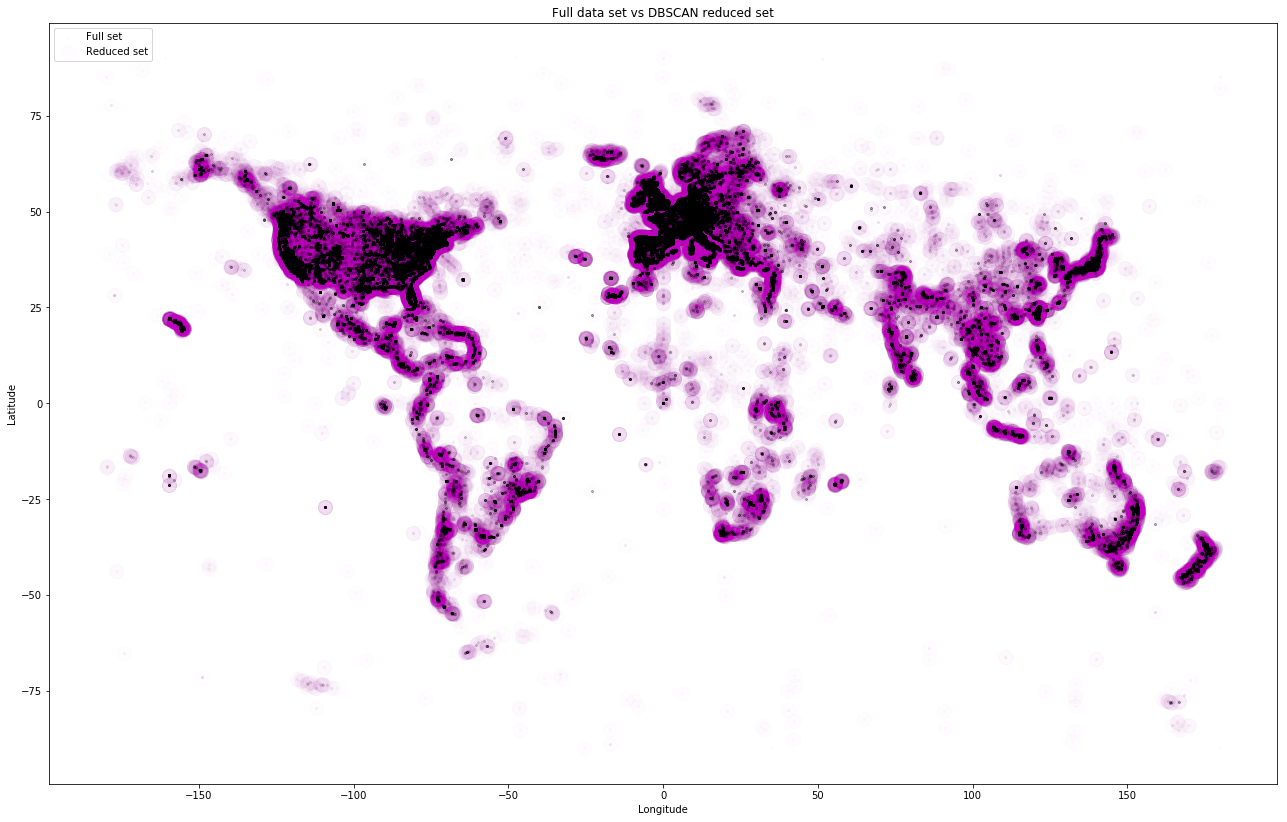

In [55]:
# plot the final reduced set of coordinate points vs the original full set
fig, ax = plt.subplots(figsize=[22,14])
rs_scatter = ax.scatter(rs['longitude'], rs['latitude'], c='m', alpha=0.01, s=200)
df_scatter = ax.scatter(df['longitude'], df['latitude'], c='k', alpha=0.01, s=5)
ax.set_title('Full data set vs DBSCAN reduced set')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend([df_scatter, rs_scatter], ['Full set', 'Reduced set'], loc='upper left')

plt.show()

In [3]:
# get colors and plot all the points, color-coded by cluster (or gray if not in any cluster, aka noise)
fig, ax = plt.subplots(figsize=[22,14])
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))

# for each cluster label and color, plot the cluster's points
for cluster_label, color in zip(unique_labels, colors):
    
    size = 30  
    # plot the points that match the current cluster label
    x_coords = coords[cluster_labels==cluster_label][:,1]
    y_coords = coords[cluster_labels==cluster_label][:,0]
    ax.scatter(x=x_coords, y=y_coords, c=color, edgecolor='k', s=size, alpha=0.01)

ax.set_title('Number of clusters: {}'.format(num_clusters))
plt.show()

NameError: name 'plt' is not defined